In [2]:
# this code is based on [ref], which is released under the MIT licesne
# make sure you reference any code you have studied as above here
# Code studied:
#   https://colab.research.google.com/drive/1_yGmk8ahWhDs23U4mpplBFa-39fsEJoT - Pytorch official VAE Guide (Mainly Loss, sampling & distributions)
#   
!pip install pytorch-msssim # For perceptual simularity

# imports
from pytorch_msssim import ssim, SSIM, MS_SSIM
import math
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
 
# hyperparameters
batch_size  = 64
capacity = 32
learning_rate = 1e-3
n_channels  = 3
latent_size = 1024
dataset = 'stl10'

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
stand_gaus = torch.distributions.Normal(torch.zeros(batch_size, latent_size).to(device), torch.ones(batch_size, latent_size).to(device))

In [3]:
# helper function to make getting another batch of data easier
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

# you may use cifar10 or stl10 datasets
if dataset == 'cifar10':
    set_mean = [0.4913997551666284, 0.48215855929893703, 0.4465309133731618]
    set_std = [0.24703225141799082, 0.24348516474564, 0.26158783926049628]
    train_set = torchvision.datasets.CIFAR10('drive/My Drive/training/cifar10', train=True, download=True, 
            transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(), 
                                                      #torchvision.transforms.Normalize(mean = set_mean,
                                                      #                                 std = set_std)
                                                      ])
            )
    train_loader = torch.utils.data.DataLoader(
        train_set,
        shuffle=True, batch_size=batch_size, drop_last=True
    )
    horse_set = [img for img, label in train_set if label == 7]
    bird_set = [img for img, label in train_set if label == 2]
    class_names = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# stl10 has larger images which are much slower to train on. You should develop your method with CIFAR-10 before experimenting with STL-10
if dataset == 'stl10':
    temp_set = torchvision.datasets.STL10('drive/My Drive/training/stl10', split='train+unlabeled', download=True, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor()]))
    bird_indc = [i for i in range(len(temp_set.labels)) if temp_set.labels[i]  == 1]
    horse_indc = [i for i in range(len(temp_set.labels)) if temp_set.labels[i]  == 6]
    train_set = temp_set#torch.utils.data.Subset(temp_set, bird_indc + horse_indc)
    horse_set = [temp_set[i][0] for i in horse_indc]
    bird_set = [temp_set[i][0] for i in bird_indc]
    train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size=batch_size, drop_last=True)
    print(train_set)
    class_names = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck'] # these are slightly different to CIFAR-10

def deNormalize(batch): # denormalize per channel
  r = batch[:,0] * set_std[0] + set_mean[0]
  b = batch[:,1] * set_std[1] + set_mean[1]
  g = batch[:,2] * set_std[2] + set_mean[2]
  return torch.stack([r, b, g], dim=1)



Extracting drive/My Drive/training/stl10/stl10_binary.tar.gz to drive/My Drive/training/stl10
Dataset STL10
    Number of datapoints: 105000
    Root location: drive/My Drive/training/stl10
    Split: train+unlabeled
    StandardTransform
Transform: Compose(
               ToTensor()
           )


In [4]:
horse_set = [temp_set[i][0] for i in horse_indc]
bird_set = [temp_set[i][0] for i in bird_indc]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: ignored

In [5]:
def calcLikelihood(x, xGen): # Calculates likelihood of input x based on decoder output (output interpretted as probabilities)
  xGenDist = torch.distributions.Normal(xGen, torch.ones_like(xGen, requires_grad=True))
  likelihood = xGenDist.log_prob(x) # P(X | Z)
  return likelihood.mean(dim=(1,2,3))


def calcKLDivergence(mu, std, z): # Monte carlo estimation
  pDist = stand_gaus # 'Target' distribution (just standard normal in this case)
  qDist = torch.distributions.Normal(mu, std)

  pLik = pDist.log_prob(z) # P(Z)
  qLik = qDist.log_prob(z) # Q(Z | X)

  KLdivergence = qLik - pLik # logQ(Z | X) − logP(Z)
  return KLdivergence.mean(-1) # Sum last dim, keep  batches

def sampleZ(mu, std): # Produces a sample of z from q(z|x), entries are output of encoder, z can be input into decoder
  #std = torch.exp(0.5 * logVar)
  zDist = torch.distributions.Normal(mu, std)
  z = zDist.rsample() # Generates n independent values, should match dimension of latent space
  return z

**Define a simple convolutional autoencoder**

In [19]:
class ConvBlock(nn.Module):
  def __init__(self, cIn, cOut, kern_size=3, pad=1, stride = 1, up=True, out_pad = 0):
    super().__init__()
    if up:
      self.conv1 = nn.Conv2d(cIn, cOut, kernel_size=kern_size, stride = stride, padding = pad, bias=False)
    else:
      self.conv1 = nn.ConvTranspose2d(cIn, cOut, kernel_size=kern_size, stride = stride, padding = pad, output_padding = out_pad, bias=False)
    self.batchNorm1 = nn.BatchNorm2d(cOut)
 
  def forward(self, inp):
    x = self.conv1(inp)
    x = self.batchNorm1(x)
    x = F.leaky_relu(x, 0.2)
    #print(x.shape)
    return x
 
class Encoder(nn.Module):
  def __init__(self, f=16):
    self.f = f
    super().__init__()
    if (dataset == 'stl10'):
      self.enc_layer = nn.Sequential(
        ConvBlock(3, f, 4, 0, 2), # 47
        #nn.MaxPool2d(kernel_size=2),
        ConvBlock(f, f*2, 4, 0, 2), # 22
        #nn.MaxPool2d(kernel_size=2),
        ConvBlock(f * 2, f * 4, 4, 0, 2), # 10
        #nn.MaxPool2d(kernel_size=2),
        ConvBlock(f * 4, f * 8, 4, 0, 2), # 4
        #ConvBlock(f * 8, f * 8, 4, 1, 2), # 4
        #nn.MaxPool2d(kernel_size=2),
        #ConvBlock(f * 8, f * 16, 4, 1, 2), # 3
        #nn.MaxPool2d(kernel_size=2),
        #ConvBlock(f * 8, f * 8, 3, 0, 1), # 1
        #nn.MaxPool2d(kernel_size=2),
        #ConvBlock(f * 16, f * 16, 3, 0, 1), # 1
      )
      self.muLin = nn.Linear(f * 8 * 4 * 4, latent_size) # This linear layer extracts the 
      self.logVarLin = nn.Linear(f * 8 * 4 * 4, latent_size)
    else:
      self.enc_layer = nn.Sequential(
        ConvBlock(3, f),
        nn.MaxPool2d(kernel_size=2),
        ConvBlock(f, f*2),
        nn.MaxPool2d(kernel_size=2),
        ConvBlock(f * 2, f * 4),
        nn.MaxPool2d(kernel_size=2),
        ConvBlock(f * 4, f * 8),
        nn.MaxPool2d(kernel_size=2),
        ConvBlock(f * 8, f * 16),
        nn.MaxPool2d(kernel_size=2),
      )
      self.muLin = nn.Linear(f * 8 * 1 * 1, latent_size)
      self.logVarLin = nn.Linear(f * 8 * 1 * 1, latent_size)
 

   
  def forward(self, x):
    x = self.enc_layer(x)
    x = x.reshape(x.shape[0], -1)
    mu = self.muLin(x)
    logVar = self.logVarLin(x)
    return mu, logVar
 
# define the model
class Decoder(nn.Module):
  def __init__(self, f=16):
    self.f = f
    super().__init__()
    if dataset == 'stl10':
      self.dec_layer = nn.Sequential(
        #nn.UpsamplingNearest2d(scale_factor=3),
        #ConvBlock(f * 8, f * 8, 3, 0, 3, False), # 3
        #nn.UpsamplingNearest2d(scale_factor=2),
        #ConvBlock(f * 8, f * 8, 4, 1, 2, False), # 6
        #nn.UpsamplingNearest2d(scale_factor=2),
        ConvBlock(f * 8, f * 4, 4, 0, 2, False), # 9
        #nn.UpsamplingNearest2d(scale_factor=2),
        ConvBlock(f * 4, f * 2, 4, 0, 2, False), # 21
        #nn.UpsamplingNearest2d(scale_factor=2),
        ConvBlock(f * 2, f, 4, 0, 2, False, 1), # 46
        #nn.UpsamplingNearest2d(scale_factor=2),
        ConvBlock(f, 3, 4, 0, 2, False), # 96
      )
      self.decFc = nn.Linear(latent_size, f * 8 * 4 * 4)
    else:
      self.dec_layer = nn.Sequential(
        nn.UpsamplingNearest2d(scale_factor=2),
        ConvBlock(f * 16, f * 8),
        nn.UpsamplingNearest2d(scale_factor=2),
        ConvBlock(f * 8, f * 4),
        nn.UpsamplingNearest2d(scale_factor=2),
        ConvBlock(f * 4, f * 2),
        nn.UpsamplingNearest2d(scale_factor=2),
        ConvBlock(f * 2, f),
        nn.UpsamplingNearest2d(scale_factor=2),
        ConvBlock(f, 3),
      )
      self.decFc = nn.Linear(latent_size, f * 8 * 4 * 4)

  
  def forward(self, x):
    x = self.decFc(x)
    x = x.reshape(x.shape[0], self.f * 8, 4, 4) # 8f x 2 x 2
    x = self.dec_layer(x)
    x = torch.sigmoid(x)
    return x

class VAE (nn.Module):
  def __init__(self, f=16):
    super().__init__()
    self.encode = Encoder(f)
    self.decode = Decoder(f)
  
  def forward(self, x):
    zMu, zLogVar = self.encode(x)
    zStd = torch.exp(0.5 * zLogVar) # Recover std from log variance
    zSample = sampleZ(zMu, zStd)
    x_hat = self.decode(zSample)
    return x_hat, zMu, zStd, zSample

 
vae = VAE(f = capacity).to(device)
mseLoss = nn.MSELoss(reduction='none')
vaeOpt = torch.optim.Adam(vae.parameters(), lr=learning_rate)
loss_fn_t = SSIM(data_range=1.0, size_average=False, channel=3, win_size=11)
ssim_channel_loss = SSIM(data_range=1.0, size_average=False, channel=1, win_size=11)
print(sum(p.numel() for p in vae.parameters()))

13969798


In [ ]:
# Calculate online feature representation loss
#x_l1, x_l2, x_l3, x_l4 = A.featureLoss(x)
#x_hat_l1, x_hat_l2, x_hat_l3, x_hat_l4 = A.featureLoss(x_hat)
#featureLoss = mseLoss(x_l1, x_hat_l1).sum(dim=(1,2,3)) + mseLoss(x_l2, x_hat_l2).sum(dim=(1,2,3)) + mseLoss(x_l3, x_hat_l3).sum(dim=(1,2,3)) + mseLoss(x_l4, x_hat_l4).sum(dim=(1,2,3))

In [7]:
def loss_fn(x, x_hat): # Doing this provided much better results
  red = 1 - ssim_channel_loss(x[:, 0].unsqueeze(1), x_hat[:, 0].unsqueeze(1))
  green = 1 - ssim_channel_loss(x[:, 1].unsqueeze(1), x_hat[:, 1].unsqueeze(1))
  blue = 1 - ssim_channel_loss(x[:, 2].unsqueeze(1), x_hat[:, 2].unsqueeze(1))
  return red + green + blue

def color_loss(x, x_hat):
  x_down = F.avg_pool2d(x, kernel_size=32)
  x_hat_down = F.avg_pool2d(x_hat, kernel_size=32)
  red = (x_down[:,0] - x_hat_down[:,0]) ** 2
  green = (x_down[:,1] - x_hat_down[:,1]) ** 2
  blue = (x_down[:,2] - x_hat_down[:,2]) ** 2
  return (red.mean(dim=(1,2)) + green.mean(dim=(1,2)) + blue.mean(dim=(1,2))) / 3

**Main training loop**

In [22]:
# training loop, you will want to train for more than 10 here!
epoch = 0
train_iterator = iter(cycle(train_loader))
e = 0
while (epoch<1000):
    
    # array(s) for the performance measures
    loss_arr = np.zeros(0)
    vae.train()
    # iterate over some of the train dateset
    for i in range(500):
        #e += 0.00001
 
        # sample x from the dataset
        x,t = next(train_iterator)
        x = x.to(device)#, t.to(device)
 
        # forward pass
        x_hat, zMu, zStd, zSample = vae(x)
        #temp = x_hat.clone()

        # Calculate losses
        KLDiv = calcKLDivergence(zMu, zStd, zSample)
        # Perceptual loss
        col_loss = 10 * color_loss(x, x_hat).mean()
        reconLoss = 3 * (1 - loss_fn_t(x, x_hat).mean()) + col_loss
        vaeLoss = 1 * KLDiv.mean() + reconLoss# + e * ((x-x_hat)**2).mean() # Aneal in exact loss

        vaeOpt.zero_grad()
        vaeLoss.backward()
        vaeOpt.step()
 
        # collect stats
        #loss_arr = np.append(loss_arr, (GANLoss).item())
    if (epoch % 10 == 0):
      torch.save({'A':vae.state_dict(), 'optimiser':vaeOpt.state_dict(), 'epoch':epoch}, 'drive/My Drive/training/save.chkpt')

    vae.eval()
    z = torch.stack([sampleZ(torch.zeros(latent_size), torch.ones(latent_size)).to(device) for i in range(batch_size)])
    gens = vae.decode(z)
    # plot some examples
    plt.rcParams['figure.dpi'] = 150
    plt.grid(False)
    print("Losses: ", reconLoss.item(), KLDiv.mean().item(), col_loss.item())
    print((abs(gens[0,0] - gens[0,2])).mean())
    print(e)
    plt.imshow(torchvision.utils.make_grid(x[:16]).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
    plt.show()
    plt.imshow(torchvision.utils.make_grid(x_hat[:16]).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
    plt.show()
    plt.imshow(torchvision.utils.make_grid(gens[:16]).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
    plt.show()
    plt.pause(0.0001)
 
    epoch = epoch+1

KeyboardInterrupt: ignored

In [ ]:
# now show your best batch of data for the submission, right click and save the image for your report
plt.rcParams['figure.dpi'] = 100
plt.grid(False)
plt.imshow(torchvision.utils.make_grid(g).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
plt.show()

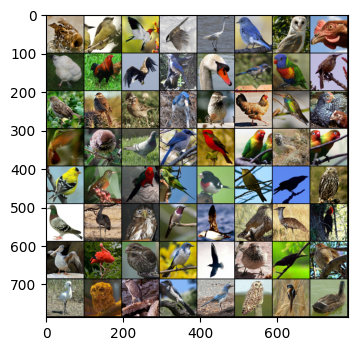

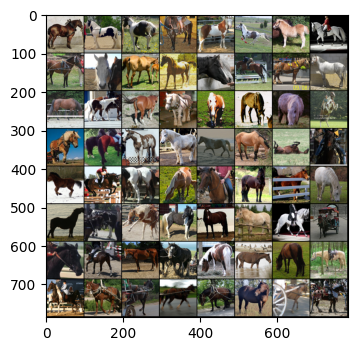

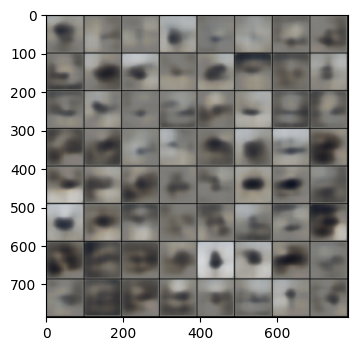

In [21]:
#@title Generate winged horses
plt.rcParams['figure.dpi'] = 100
offset = 200 # 1000 good
b = torch.stack(bird_set[offset + 8:offset+64+8])
h = torch.stack(horse_set[offset:offset+64])
m, lv = vae.encode(b.to(device))
s = torch.exp(0.5 * lv)
zSamp1 = sampleZ(m, s)

m, lv = vae.encode(h.to(device))
s = torch.exp(0.5 * lv)
zSamp2 = sampleZ(m, s)

bal = 0.5

zSamp = bal * zSamp2 + (1 - bal) * zSamp1
im = vae.decode(zSamp)

#plt.imshow(im.squeeze(0).permute(1, 2, 0).detach().contiguous().cpu(), cmap=plt.cm.binary)
plt.imshow(torchvision.utils.make_grid(b[0:64]).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
plt.show()
plt.imshow(torchvision.utils.make_grid(h[0:64]).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
plt.show()
plt.imshow(torchvision.utils.make_grid(im[0:64]).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)

In [ ]:
def color_loss(x, x_hat):
  x_down = F.avg_pool2d(x, kernel_size=6)
  x_hat_down = F.avg_pool2d(x_hat, kernel_size=6)
  red = (x_down[:,0].mean(dim=(1,2)) - x_hat_down[:,0].mean(dim=(1,2))) ** 2
  green = (x_down[:,1].mean(dim=(1,2)) - x_hat_down[:,1].mean(dim=(1,2))) ** 2
  blue = (x_down[:,2].mean(dim=(1,2)) - x_hat_down[:,2].mean(dim=(1,2))) ** 2
  return (red + green + blue) / 3

In [ ]:
# optional example code to save your training progress for resuming later if you authenticated Google Drive previously
torch.save({'A':vae.state_dict(), 'optimiser':vaeOpt.state_dict(), 'epoch':epoch}, 'drive/My Drive/training/save.chkpt')

In [ ]:
# optional example to resume training if you authenticated Google Drive previously
params = torch.load('drive/My Drive/training/save.chkpt')
vae.load_state_dict(params['A'])
vaeOpt.load_state_dict(params['optimiser'])
epoch = params['epoch']